In [460]:
 # Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi 
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
import requests
import urllib.request
import json
import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

In [461]:
 # Load .env enviroment variables
load_dotenv()

True

In [462]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
print(f"ALP Key type:{type(alpaca_secret_key)}")

ALP Key type:<class 'str'>


In [463]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [464]:
# Set start and end dates of five years back from today.

start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-05', tz='America/New_York').isoformat()
timeframe='1D'

In [465]:
# Get 5 years' worth of historical data for SPY 
tickers = ['SPY']
df_sp500_data = alpaca.get_barset(tickers, timeframe, start = start_date, end = end_date).df
# Display sample data
df_sp500_data.head()

SPY                                    
                             open    high      low   close     volume
2015-01-02 00:00:00-05:00  206.38  206.88  204.180  205.41   94506045
2015-01-05 00:00:00-05:00  204.17  204.37  201.350  201.80  133100354
2015-01-06 00:00:00-05:00  202.09  202.72  198.855  199.82  166955423
2015-01-07 00:00:00-05:00  201.42  202.72  200.880  202.34  103285826
2015-01-08 00:00:00-05:00  204.00  206.16  203.990  205.92  112316394

In [466]:
sp500_df = pd.DataFrame()
sp500_df['open'] = df_sp500_data['SPY']['open']
sp500_df['high'] = df_sp500_data['SPY']['high']
sp500_df['low'] = df_sp500_data['SPY']['low']
sp500_df['close'] = df_sp500_data['SPY']['close']
sp500_df['volume'] = df_sp500_data['SPY']['volume']
sp500_df['date'] = df_sp500_data.index.date
sp500_df.reset_index(inplace=True)
sp500_df = sp500_df[['date','open','high','low','close','volume']]
sp500_df.head()

,date,open,high,low,close,volume
0,2015-01-02,206.38,206.88,204.180,205.41,94506045
1,2015-01-05,204.17,204.37,201.350,201.80,133100354
2,2015-01-06,202.09,202.72,198.855,199.82,166955423
3,2015-01-07,201.42,202.72,200.880,202.34,103285826
4,2015-01-08,204.00,206.16,203.990,205.92,112316394


In [467]:
sp500_df = sp500_df.drop(['open','high','low','volume'], axis =1)



In [468]:
sp500_df['date']=pd.to_datetime(sp500_df['date'])
sp500_df['close']=sp500_df['close'].pct_change().astype(str).astype('float64')

sp500_df.head()                                

,date,close
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [469]:
#df_sp500_data.index=df_sp500_data.index.date
#df_sp500_data.head()

In [470]:
sp500_daily_returns = sp500_df
sp500_daily_returns.head()

,date,close
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [471]:
sp500_daily_returns.columns

Index(['date', 'close'], dtype='object')

In [472]:
columns = ['Date', 'Std']
sp500_daily_returns.columns = columns
sp500_daily_returns.head()

,Date,Std
0,2015-01-02,NaN
1,2015-01-05,-0.017575
2,2015-01-06,-0.009812
3,2015-01-07,0.012611
4,2015-01-08,0.017693


In [473]:
#calculate daily standard deviation of the S&P 500
#daily_std = sp500_daily_returns.std()
#daily_std

In [474]:
#calculate the annualized std(252 trading days)
#annualized_std = daily_std*np.sqrt(252)
#annualized_std

In [475]:
# Calculate the rolling standard deviation for S&P 500

rolling_std = sp500_daily_returns.rolling(window=21).std()
rolling_std

,Std
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1508,0.005931
1509,0.005792
1510,0.005436
1511,0.006268


In [476]:
# Plot the rolling standard deviation
sp500_rolling_plot = rolling_std.hvplot()
sp500_rolling_plot

:Curve   [index]   (Std)

In [477]:
load_dotenv()
access_token = os.getenv("COIN_API")
headers = { 'Authorization': 'Bearer ' + access_token }
puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
response = requests.get(puell_url, headers=headers)

In [478]:
response


<Response [200]>

In [479]:
puell_data = response.json()

puell_df = pd.DataFrame(data=puell_data['result']['data'])
puell_df['date']=pd.to_datetime(puell_df['date'])
#puell_df=puell_df.set_index('date')
#puell_df = puell_df.pct_change()

In [480]:
def get_puell_multiple_data():
    
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
    response = requests.get(puell_url, headers=headers)
    puell_data = response.json()

    puell_df = pd.DataFrame(data=puell_data['result']['data'])
    puell_df['date']=pd.to_datetime(puell_df['date'])
    
    return puell_df

In [481]:
puell_plot = puell_df.hvplot(x='date',y='puell_multiple',sort_date = True)

In [482]:
puell_plot = puell_df.hvplot()
puell_plot

:Curve   [index]   (puell_multiple)

In [483]:
#puell = get_puell_multiple_data()

In [484]:
#Puell Multiple = Daily Coin Issuance(USD)/MA365(Daily Coin Issuance(USD))

In [485]:
#Indicator Overview
#This metric looks at the supply side of Bitcoin's economy - bitcoin miners and their revenue.
#It explores market cycles from a mining revenue perspective. Bitcoin miners are sometimes referred to as compulsory sellers due to their need to cover fixed costs of mining hardware in a market where price is extremely volatile. The revenue they generate can therefore influence price over time.

#The Puell Multiple is calculated by dividing the daily issuance value of bitcoins (in USD) by the 365-day moving average of daily issuance value.

In [486]:
#How It Can Be Used
#There are periods of time where the value of bitcoins being mined and entering the ecosystem is too great or too little relative to historical norms.
#Understanding these periods of time can be beneficial to the strategic Bitcoin investor.

#The chart below highlights periods where the value of Bitcoin's issued on a daily basis has historically been extremely low , which produced outsized returns for Bitcoin investors who bought Bitcoin here. It also shows periods where the daily issuance value was extremely high, providing advantageous profit-taking for Bitcoin investors who sold here.

In [487]:
'''
fig = px.line(
    puell,
    x='date',
    y='puell_multiple',
    title='Bitcoin Puell Multiple',
    labels={'date':'Daily','puell_multiple':'Puell Multiple'})
fig.show()
'''

"\nfig = px.line(\n    puell,\n    x='date',\n    y='puell_multiple',\n    title='Bitcoin Puell Multiple',\n    labels={'date':'Daily','puell_multiple':'Puell Multiple'})\nfig.show()\n"

In [488]:
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }

In [502]:
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    #BTC_price_df = BTC_price_df.dropna()
    #BTC_price_df = BTC_price_df.set_index('date')
    #BTC_daily_returns_df = BTC_price_df.pct_change()

    BTC_price_df.head()

,date,price_usd_close
0,2021-01-23,32085.301667
1,2021-01-22,32968.301667
2,2021-01-21,30848.486667
3,2021-01-20,35481.915000
4,2021-01-19,35888.901667


In [503]:
#calculate cumulative returns
#btc_cumulative_returns = (1+ BTC_daily_returns_df).cumprod()-1
#btc_cumulative_returns.head()

In [504]:
#btc_cumulative_returns.plot(figsize=(10,5), title="Cumulative Returns of BTC Since 2015")

In [505]:
btc_plot = BTC_price_df.hvplot(x='date',y='price_usd_close',sort_date = True)

In [506]:
btc_plot

:Curve   [date]   (price_usd_close)

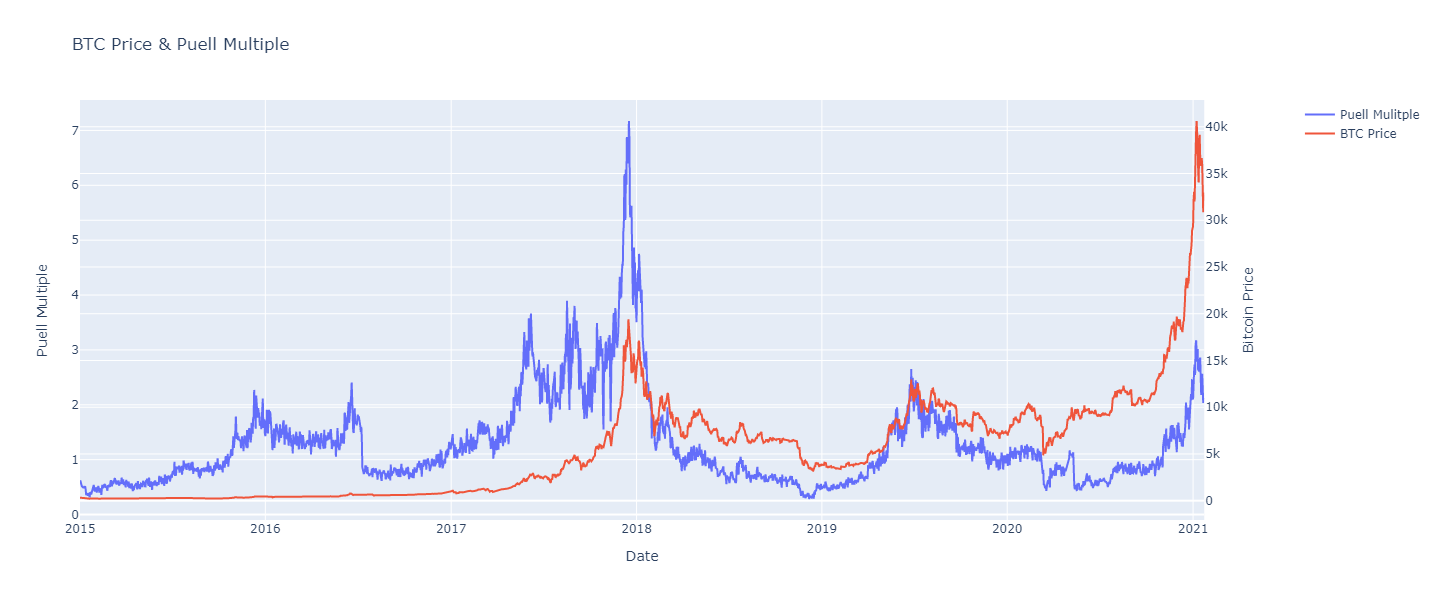

In [507]:
fig3 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig3.add_trace(
    go.Scatter(mode = 'lines',x=puell_df['date'],y=puell_df['puell_multiple'], name = 'Puell Mulitple'),
    secondary_y=False 
)

fig3.add_trace(
    go.Scatter(mode = 'lines',x=BTC_price_df['date'], y =BTC_price_df ['price_usd_close'], name = 'BTC Price'),
    secondary_y=True 
)

fig3.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & Puell Multiple'
)

fig3.update_xaxes(title_text = 'Date')

fig3.update_yaxes(title_text='Puell Multiple', secondary_y= False)
fig3.update_yaxes(title_text='Bitcoin Price', secondary_y= True)



fig3.show()

In [508]:
def get_btc_price():

    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    
    BTC_price_df = BTC_price_df.dropna()
    
    return BTC_price_df

In [509]:
#btc = get_btc_price()

In [510]:
'''
fig1 = px.line(
    btc,
    x='date',
    y='price_usd_close',
    title='Bitcoin Closing Prices',
    labels={'date':'Daily','price_usd_close':'Daily Bitcoin Price'})
fig1.show()
'''

"\nfig1 = px.line(\n    btc,\n    x='date',\n    y='price_usd_close',\n    title='Bitcoin Closing Prices',\n    labels={'date':'Daily','price_usd_close':'Daily Bitcoin Price'})\nfig1.show()\n"

In [511]:
BTC_price_df.head()

,date,price_usd_close
0,2021-01-23,32085.301667
1,2021-01-22,32968.301667
2,2021-01-21,30848.486667
3,2021-01-20,35481.915000
4,2021-01-19,35888.901667


In [512]:
#BTC_price_df = BTC_price_df.set_index('date')
#BTC_price_df

In [513]:
BTC_price_df['date']=pd.to_datetime(BTC_price_df['date'])
BTC_price_df['price_usd_close']=BTC_price_df['price_usd_close'].pct_change().astype(str).astype('float64')

BTC_price_df.head()    

,date,price_usd_close
0,2021-01-23,NaN
1,2021-01-22,0.027520
2,2021-01-21,-0.064299
3,2021-01-20,0.150200
4,2021-01-19,0.011470


In [514]:
btc_daily_returns=BTC_price_df
btc_daily_returns.head()

,date,price_usd_close
0,2021-01-23,NaN
1,2021-01-22,0.027520
2,2021-01-21,-0.064299
3,2021-01-20,0.150200
4,2021-01-19,0.011470


In [515]:
btc_daily_returns.columns

Index(['date', 'price_usd_close'], dtype='object')

In [518]:
columns=['Date','Std']
btc_daily_returns.columns = columns
btc_daily_returns.head()

,Date,Std
0,2021-01-23,NaN
1,2021-01-22,0.027520
2,2021-01-21,-0.064299
3,2021-01-20,0.150200
4,2021-01-19,0.011470


In [519]:
btc_rolling_plot = btc_daily_returns.hvplot(x='Date',y='Std',sort_date = True)

In [520]:
#btc_cumulative_r_plot = btc_cumulative_returns.hvplot(x='date',y='price_usd_close',sort_date = True)

In [521]:
btc_rolling_plot

:Curve   [Date]   (Std)

In [522]:
btc_daily_std = btc_daily_returns.std()
btc_daily_std

Std    0.040935
dtype: float64

In [523]:
btc_annual_std = btc_daily_std*np.sqrt(252)
btc_annual_std

Std    0.649824
dtype: float64

In [531]:
btc_rolling_std = btc_daily_returns.rolling(window=21).std()
btc_rolling_std

,Std
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
2210,0.084950
2211,0.083542
2212,0.084022
2213,0.086384


In [532]:
#btc_plot = BTC_price_df.hvplot(x='date',y='price_usd_close',sort_date = True)

In [536]:
btc_rolling_plot = btc_rolling_std.hvplot(x='Date',y='Std',sort_date=True)

In [537]:
btc_rolling_plot

:Curve   [Date]   (Std)

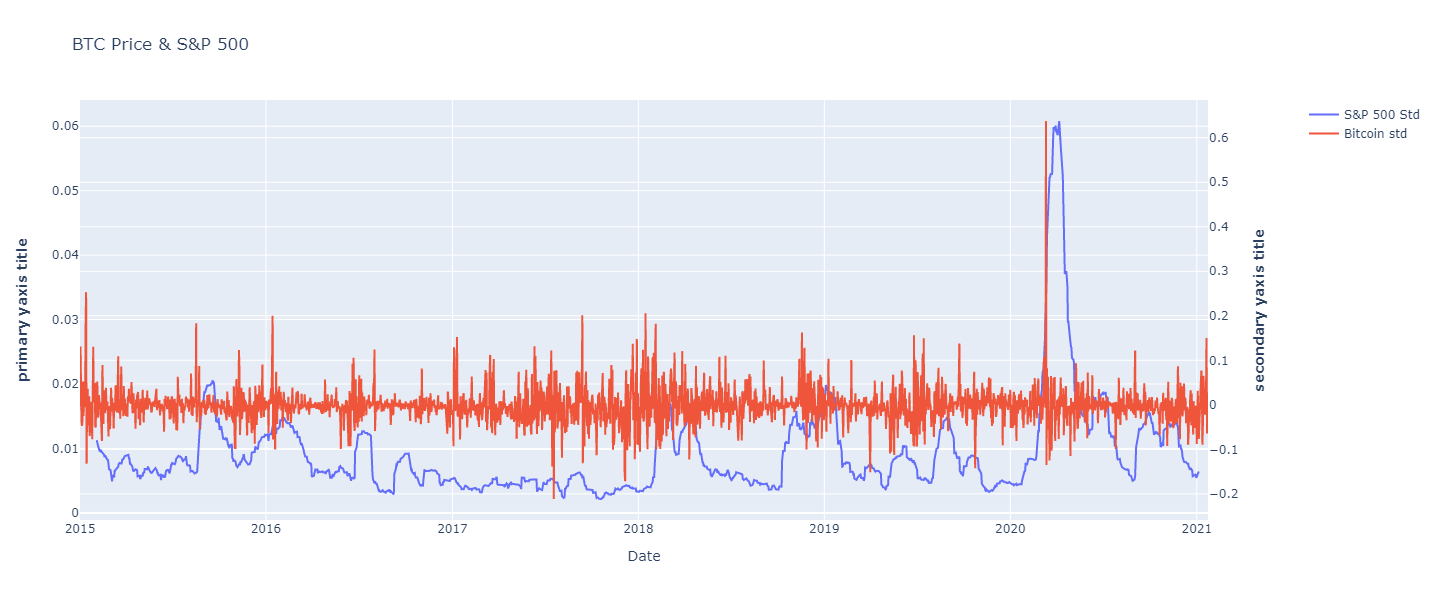

In [539]:
fig4 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig4.add_trace(
    go.Scatter(mode = 'lines',x=sp500_daily_returns['Date'],y=rolling_std['Std'], name = 'S&P 500 Std'),
    secondary_y=False 
)

fig4.add_trace(
    go.Scatter(mode = 'lines',x=btc_daily_returns['Date'], y =BTC_price_df ['Std'], name = 'Bitcoin std'),
    secondary_y=True 
)

fig4.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & S&P 500'
)

fig4.update_xaxes(title_text = 'Date')

fig4.update_yaxes(title_text='<b>primary<b> yaxis title', secondary_y= False)
fig4.update_yaxes(title_text='<b>secondary<b> yaxis title', secondary_y= True)



fig4.show()
